## Logistic regression

Good baseline for more sophisticated mechanisms. From averaged cross validation it looks like it works well for bigger class (negative, 0.83) and worse for smaller one (positive, 0.55).

Replacing CountVectorizer with TfIdfVectorizer improved averaged CV results (0.84 / 0.59). From EDA (TruncatedSGD) it can be seen that it helps to distinguish the targets. Interestingly, accuracies went down.

Lemmatization didn't help.

In [22]:
%load_ext autoreload
%autoreload 2

import re
import itertools
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [23]:
train_df = pd.read_csv('../data/train.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)
test_df = pd.read_csv('../data/test.csv', encoding='utf-8', warn_bad_lines=True, error_bad_lines=False)

train_df[:3]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


## Preprocessing

In [24]:
EXTENDED_STRIP_REGEX = r'[!"#$%&()\*\+,-\./:;„”<=>?@\[\\\]^_`{|}~\']'
REMOVE_NUMERICAL = r'[0-9]'

def _preprocessing(txt: str) -> str:
    txt = txt.lower()
    txt = re.sub(EXTENDED_STRIP_REGEX, '', txt)
    txt = re.sub(REMOVE_NUMERICAL, '', txt)
    return txt

train_df['text_preproc'] = train_df['text'].apply(_preprocessing)

nlp = spacy.load('en_core_web_sm')

# disable not used parts of pipeline
def _lemma(txt: str) -> str:
    return ' '.join([d.lemma_ for d in nlp(txt)])

# train_df['text_preproc_lemma'] = train_df['text_preproc'].apply(_lemma)

train_df['text_preproc']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610        m  utckm s of volcano hawaii httptcozdtoydebj
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text_preproc, Length: 7613, dtype: object

## Data split

In [25]:
X = train_df['text_preproc']
y = train_df['target']

X[:3]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
Name: text_preproc, dtype: object

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:3]

4996    courageous and honest analysis of need to use ...
3263    zachzaidman thescore wld b a shame if that gol...
4907    tell barackobama to rescind medals of honor gi...
Name: text_preproc, dtype: object

## Vectorization

In [27]:
with open('../resources/stopwords_en.txt', encoding='utf-8') as f:
    stopwords = [line.rstrip() for line in f]

stopwords[:3]

['i', 'me', 'my']

In [28]:
vec = TfidfVectorizer(min_df=4, max_df=0.3)
vec.fit(X_train)
X_train_vec = vec.transform(X_train)
X_test_vec = vec.transform(X_test)

print(vec.get_feature_names())

['aba', 'abandoned', 'abbswinston', 'abc', 'abcnews', 'ability', 'ablaze', 'able', 'about', 'above', 'absolutely', 'abstorm', 'access', 'accident', 'accidentally', 'accidents', 'according', 'account', 'accused', 'acres', 'across', 'act', 'action', 'actions', 'activated', 'activates', 'actual', 'actually', 'add', 'added', 'admits', 'adult', 'advance', 'advisory', 'af', 'affected', 'afghan', 'afghanistan', 'afraid', 'africa', 'after', 'afternoon', 'aftershock', 'again', 'against', 'age', 'ago', 'agree', 'agreed', 'ah', 'ahead', 'aid', 'aim', 'aint', 'air', 'aircraft', 'airlines', 'airplane', 'airport', 'aka', 'al', 'alabama', 'alarm', 'alaska', 'alberta', 'album', 'alcohol', 'alert', 'alive', 'all', 'allah', 'alleged', 'allow', 'allowed', 'allows', 'almost', 'alone', 'along', 'alps', 'already', 'also', 'always', 'am', 'amazing', 'amazon', 'ambulance', 'america', 'american', 'americans', 'americas', 'amid', 'among', 'amongst', 'amp', 'amsterdam', 'an', 'analysis', 'ancient', 'and', 'angel

In [29]:
log_reg = LogisticRegression()
log_reg.fit(X_train_vec, y_train)

LogisticRegression()

In [30]:
print(log_reg.score(X_train_vec, y_train))
print(log_reg.score(X_test_vec, y_test))

0.8628899835796388
0.8003939592908733


[[770 104]
 [200 449]]
Normalized confusion matrix


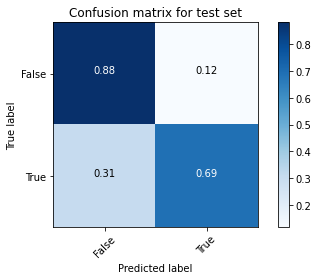

In [31]:
y_pred_test = log_reg.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred_test)

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix for test set',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.print(classification_report(y_test, y_pred_test))
    """
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plot_confusion_matrix(cm, [False, True])

In [32]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       874
           1       0.81      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



## Cross validation

TRAIN: 5709 TEST: 1904
CV ACCURACY: 0.8668768610965143


TRAIN: 5710 TEST: 1903
CV ACCURACY: 0.8651488616462347


TRAIN: 5710 TEST: 1903
CV ACCURACY: 0.8674255691768826


TRAIN: 5710 TEST: 1903
CV ACCURACY: 0.8609457092819615


[[3631  711]
 [1344 1927]]
Normalized confusion matrix


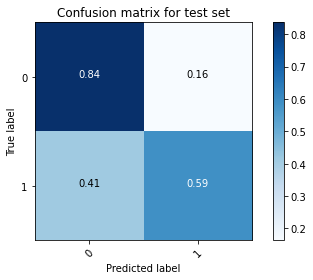

In [33]:
X_cv = train_df['text_preproc']
y_cv = train_df['target']

CONF_MATRIXES = []

skf = StratifiedKFold(n_splits=4)
for train_idx, test_idx in skf.split(X_cv, y_cv):
    print('TRAIN:', len(train_idx), 'TEST:', len(test_idx))
    X_train_cv, X_test_cv = X_cv[train_idx], X_cv[test_idx]
    y_train_cv, y_test_cv = y_cv[train_idx], y_cv[test_idx]

    vec_cv = TfidfVectorizer(min_df=4, max_df=0.3)
    X_train_vec_cv = vec_cv.fit_transform(X_train_cv)
    X_test_vec_cv = vec_cv.transform(X_test_cv)

    log_reg_cv = LogisticRegression()
    log_reg_cv.fit(X_train_vec_cv, y_train_cv)
    accuracy_cv = log_reg_cv.score(X_train_vec_cv, y_train_cv)

    print(f'CV ACCURACY: {accuracy_cv}')
    y_pred_cv = log_reg_cv.predict(X_test_vec_cv)
    cm = confusion_matrix(y_test_cv, y_pred_cv)
    CONF_MATRIXES.append(cm)
    print('\n')

# overall results
cm = np.array(CONF_MATRIXES).sum(axis=0)
plot_confusion_matrix(cm, [0, 1])

## Final model training

0.8616839616445554
[[4062  280]
 [ 773 2498]]
Normalized confusion matrix
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4342
           1       0.90      0.76      0.83      3271

    accuracy                           0.86      7613
   macro avg       0.87      0.85      0.86      7613
weighted avg       0.87      0.86      0.86      7613



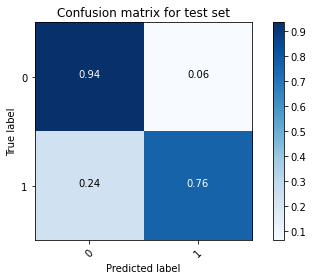

In [34]:
vec = TfidfVectorizer(min_df=4, max_df=0.3)
X_vec = vec.fit_transform(X)

log_reg = LogisticRegression()
log_reg.fit(X_vec, y)
print(log_reg.score(X_vec, y))

y_pred = log_reg.predict(X_vec)

cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, [0, 1])

print(classification_report(y, y_pred))

In [35]:
test_df[:3]

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [36]:
test_df['text_preproc'] = test_df['text'].apply(_preprocessing)
X_out = test_df['text_preproc']
X_out

0                      just happened a terrible car crash
1       heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   apocalypse lighting spokane wildfires
4             typhoon soudelor kills  in china and taiwan
                              ...                        
3258    earthquake safety los angeles ûò safety faste...
3259    storm in ri worse than last hurricane my citya...
3260    green line derailment in chicago httptcoutbxlc...
3261    meg issues hazardous weather outlook hwo httpt...
3262    cityofcalgary has activated its municipal emer...
Name: text_preproc, Length: 3263, dtype: object

In [37]:
X_out_vec = vec.transform(X_out)
X_out_vec

<3263x3300 sparse matrix of type '<class 'numpy.float64'>'
	with 31597 stored elements in Compressed Sparse Row format>

In [38]:
y_out_pred = log_reg.predict(X_out_vec)
y_out_pred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [39]:
file = pd.DataFrame({
   'id': test_df['id'],
   'target': y_out_pred
})

file.to_csv('disaster-tweets-log-reg-tfidf.csv', index=False)